In [119]:
import torch
from torch import nn

In [120]:
pip install torchmetrics

In [121]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [122]:
import os
from pathlib import Path

image_path = Path('/content/drive/MyDrive/archive')
train_dir = image_path / 'Training'
test_dir = image_path / 'Testing'
classes = {'no_tumor':0, 'pituitary_tumor':1}
train_dir

PosixPath('/content/drive/MyDrive/archive/Training')

In [123]:
# import cv2
# X = []
# Y = []
# for cls in classes:
#   pth = '/content/drive/MyDrive/archive/Training/'+cls
#   for j in os.listdir(pth):
#     img = cv2.imread(pth+'/'+j, 0)
#     img = cv2.resize(img, (200, 200))
#     X.append(img)
#     Y.append(classes[cls])

Random image path: /content/drive/MyDrive/archive/Training/pituitary_tumor/p (91).jpg
Image class: pituitary_tumor
Image height: 512
Image width: 512


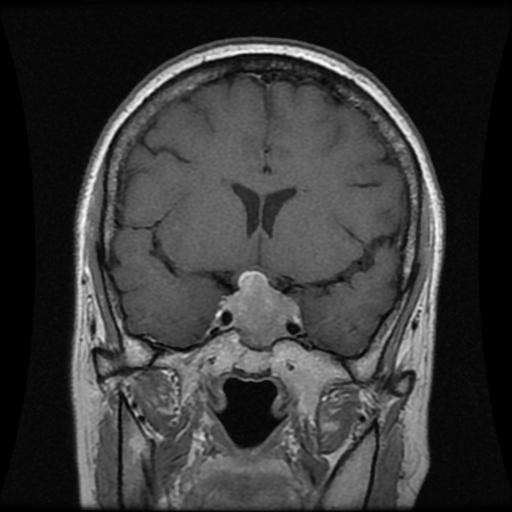

In [124]:
import random
from PIL import Image

random.seed(42)

image_path_list = list(image_path.glob("*/*/*.jpg"))

random_image_path = random.choice(image_path_list)

image_class = random_image_path.parent.stem

img = Image.open(random_image_path)

# 5. Print metadata
print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height}")
print(f"Image width: {img.width}")
img

In [125]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

In [126]:
data_transform = transforms.Compose([
  # Resize the images to 64x64x3 (64 height, 64 width, 3 color channels)
  transforms.Resize(size=(64, 64)),
  # Flip the images randomly on horizontal
  transforms.RandomHorizontalFlip(p=0.5),
  # Turn the image into a torch.Tensor
  transforms.ToTensor() # converts all pixel values from 0-255 to be between 0-1
])

In [127]:
random.sample(image_path_list, k=3)

[PosixPath('/content/drive/MyDrive/archive/Training/no_tumor/image(8).jpg'),
 PosixPath('/content/drive/MyDrive/archive/Testing/no_tumor/image(9).jpg'),
 PosixPath('/content/drive/MyDrive/archive/Training/no_tumor/image(45).jpg')]

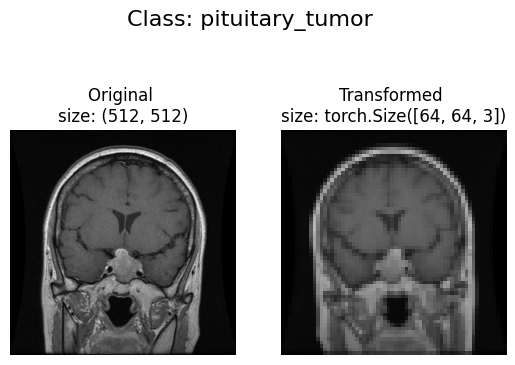

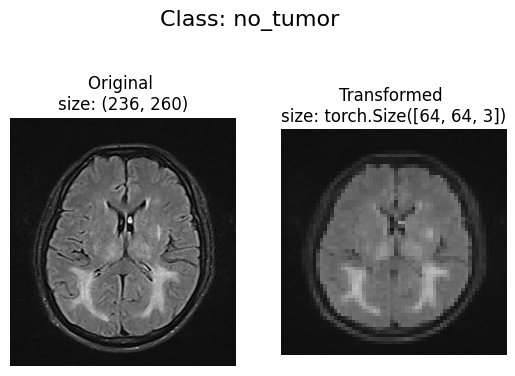

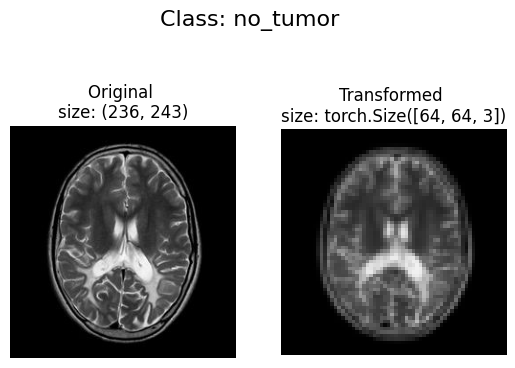

In [128]:
import numpy as np
import matplotlib.pyplot as plt


def plot_transformed_images(image_paths, transform, n=3, seed=42):
  """Plots a series of random images from image_paths."""
  random.seed(seed)
  random_image_paths = random.sample(image_paths, k=n)
  for image_path in random_image_paths:
    with Image.open(image_path) as f:
      fig, ax = plt.subplots(nrows=1, ncols=2)
      ax[0].imshow(f)
      ax[0].set_title(f"Original \nsize: {f.size}")
      ax[0].axis("off")

      # Transform and plot image
      # permute() the image to make sure it's compatible with matplotlib
      transformed_image = transform(f).permute(1, 2, 0)
      ax[1].imshow(transformed_image)
      ax[1].set_title(f"Transformed \nsize: {transformed_image.shape}")
      ax[1].axis("off")

      fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=16)

plot_transformed_images(image_path_list,
                        transform=data_transform,
                        n=3)

In [129]:
#Loading image datasets

from torchvision import datasets
train_data = datasets.ImageFolder(root=train_dir, # target folder of images
                                  transform=data_transform, # transforms to perform on data (images)
                                  target_transform=None) # transforms to perform on labels (if necessary)

test_data = datasets.ImageFolder(root=test_dir,
                                 transform=data_transform,
                                 target_transform=None)

train_data, test_data

(Dataset ImageFolder
     Number of datapoints: 1222
     Root location: /content/drive/MyDrive/archive/Training
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 179
     Root location: /content/drive/MyDrive/archive/Testing
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ))

In [130]:
class_names = train_data.classes
class_names

['no_tumor', 'pituitary_tumor']

In [131]:
len(train_data), len(test_data)

(1222, 179)

In [132]:
# Turn train and test Datasets into DataLoaders


from torch.utils.data import DataLoader
#could change batchsize
BATCH_SIZE = 1
train_dataloader = DataLoader(dataset=train_data,
                              batch_size=BATCH_SIZE,
                              num_workers=os.cpu_count(),
                              shuffle=True)

test_dataloader = DataLoader(dataset=test_data,
                             batch_size=BATCH_SIZE,
                             num_workers=os.cpu_count(),
                             shuffle=False)

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7d15bc463a00>,
 <torch.utils.data.dataloader.DataLoader at 0x7d15aff4feb0>)

In [133]:
import torch
from torch import nn

class TinyVGG(nn.Module):
  def __init__(self, input_shape, hidden_units, output_shape):
    super().__init__()
    self.conv_block_1 = nn.Sequential(
        nn.Conv2d(in_channels=input_shape,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2)
    )
    self.conv_block_2 = nn.Sequential(
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2)
    )
    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Dropout(p=0.5), #added this to prevent overfitting.
        nn.Linear(in_features=hidden_units*16*16,
                  out_features=output_shape))

  def forward(self, x):
    x = self.conv_block_1(x)
    # print(f"Layer 1 shape: {x.shape}")
    x = self.conv_block_2(x)
    # print(f"Layer 2 shape: {x.shape}")
    x = self.classifier(x)
    # print(f"Layer 3 shape: {x.shape}")
    return x

In [134]:
model_0 = TinyVGG(input_shape = 3,
                  hidden_units=10,
                  output_shape=len(class_names)).to(device)
model_0


TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Dropout(p=0.5, inplace=False)
    (2): Linear(in_features=2560, out_features=2, bias=True)
  )
)

In [135]:
from sklearn.metrics import precision_score, f1_score

def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer):

  # Put the model in train mode
  model.train()

  # Setup train loss and train accuracy values
  train_loss, train_acc = 0, 0
  all_preds = []
  all_labels = []

  # Loop through data loader and data batches
  for batch, (X, y) in enumerate(dataloader):
    # Send data to target device
    X, y = X.to(device), y.to(device)

    # 1. Forward pass
    y_pred = model(X)
    # print(y_pred)

    # 2. Calculate and accumulate loss
    loss = loss_fn(y_pred, y)
    train_loss += loss.item()

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backward
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    # Calculate and accumualte accuracy metric across all batches
    y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
    train_acc += (y_pred_class == y).sum().item()/len(y_pred)

    all_preds.append(y_pred_class.cpu())
    all_labels.append(y.cpu())

  # Concatenate all predictions and labels across batches
  all_preds = torch.cat(all_preds)
  all_labels = torch.cat(all_labels)

# Calculate precision and F1 score using sklearn (on CPU tensors)
  train_precision = precision_score(all_labels, all_preds, average='weighted')
  train_f1 = f1_score(all_labels, all_preds, average='weighted')

  # Adjust metrics to get average loss and average accuracy per batch
  train_loss = train_loss / len(dataloader)
  train_acc = train_acc / len(dataloader)

  return train_loss, train_acc, train_precision, train_f1

In [136]:
def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module):

  # Put model in eval mode
  model.eval()

  # Setup the test loss and test accuracy values
  test_loss, test_acc = 0, 0
  all_preds = []
  all_labels = []

  # Turn on inference context manager
  with torch.inference_mode():
    # Loop through DataLoader batches
    for batch, (X, y) in enumerate(dataloader):
      # Send data to target device
      X, y = X.to(device), y.to(device)

      # 1. Forward pass
      test_pred_logits = model(X)

      # 2. Calculate and accumulate loss
      loss = loss_fn(test_pred_logits, y)
      test_loss += loss.item()

      # Calculate and accumulate accuracy
      test_pred_labels = test_pred_logits.argmax(dim=1)
      test_acc += ((test_pred_labels == y).sum().item() / len(test_pred_labels))

      # Collect all predictions and labels
      all_preds.append(test_pred_labels.cpu())
      all_labels.append(y.cpu())

  # Concatenate all predictions and labels across batches
  all_preds = torch.cat(all_preds)
  all_labels = torch.cat(all_labels)

  # Calculate precision and F1 score using sklearn (on CPU tensors)
  num_classes = len(class_names)
  all_preds = all_preds.numpy()
  all_labels = all_labels.numpy()

  test_precision = precision_score(all_labels, all_preds, average='weighted', labels=range(num_classes))
  test_f1 = f1_score(all_labels, all_preds, average='weighted', labels=range(num_classes))

  # Adjust metrics to get average loss and accuracy per batch
  test_loss = test_loss / len(dataloader)
  test_acc = test_acc / len(dataloader)

  return test_loss, test_acc, test_precision, test_f1

In [137]:
#MSE, logloss, crossEntropyLoss is first one used
from tqdm.auto import tqdm

def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5):

  # Create results dictionary
  results = {"train_loss": [],
             "train_acc": [],
             "train_precision": [],
             "train_f1score": [],
             "test_loss": [],
             "test_acc": [],
             "test_precision": [],
             "test_f1score": []}

  # Loop through the training and testing steps for a number of epochs
  for epoch in tqdm(range(epochs)):
    # Train step
    train_loss, train_acc, train_precision, train_f1score = train_step(model=model,
                                       dataloader=train_dataloader,
                                       loss_fn=loss_fn,
                                       optimizer=optimizer)
    # Test step
    test_loss, test_acc, test_precision, test_f1score = test_step(model=model,
                                    dataloader=test_dataloader,
                                    loss_fn=loss_fn)

    # Print out what's happening
    print(f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"train_precision: {train_precision:.4f} | "
          f"train_f1score: {train_f1score:.4f} | "
          f"test_loss: {test_loss:.4f} | "
          f"test_acc: {test_acc:.4f} | "
          f"test_precision: {test_precision:.4f} | "
          f"test_f1score: {test_f1score:.4f}"
    )

    # Update the results dictionary
    results["train_loss"].append(train_loss)
    results["train_acc"].append(train_acc)
    results["train_precision"].append(train_precision)
    results["train_f1score"].append(train_f1score)
    results["test_loss"].append(test_loss)
    results["test_acc"].append(test_acc)
    results["test_precision"].append(test_precision)
    results["test_f1score"].append(test_f1score)

  # Return the results dictionary
  return results


In [138]:
#Train for 5 epochs
torch.manual_seed(42)
torch.cuda.manual_seed(42)
model_0 = TinyVGG(input_shape=3,
                  hidden_units=10,
                  output_shape=len(class_names)).to(device)

loss_fn=nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_0.parameters(), lr=0.001)

model_0_results = train(model=model_0,
                        train_dataloader=train_dataloader,
                        test_dataloader=test_dataloader,
                        optimizer=optimizer,
                        epochs=5)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.5681 | train_acc: 0.7259 | train_precision: 0.7508 | train_f1score: 0.6626 | test_loss: 0.5224 | test_acc: 0.7207 | test_precision: 0.7179 | test_f1score: 0.7178
Epoch: 2 | train_loss: 0.2808 | train_acc: 0.8895 | train_precision: 0.8914 | train_f1score: 0.8859 | test_loss: 0.4496 | test_acc: 0.7877 | test_precision: 0.7865 | test_f1score: 0.7862
Epoch: 3 | train_loss: 0.2004 | train_acc: 0.9272 | train_precision: 0.9274 | train_f1score: 0.9261 | test_loss: 0.5573 | test_acc: 0.7989 | test_precision: 0.8048 | test_f1score: 0.7929
Epoch: 4 | train_loss: 0.1790 | train_acc: 0.9419 | train_precision: 0.9418 | train_f1score: 0.9413 | test_loss: 0.4883 | test_acc: 0.7933 | test_precision: 0.8138 | test_f1score: 0.7820
Epoch: 5 | train_loss: 0.1608 | train_acc: 0.9493 | train_precision: 0.9491 | train_f1score: 0.9490 | test_loss: 0.4117 | test_acc: 0.8436 | test_precision: 0.8534 | test_f1score: 0.8389


In [ ]:
# Train for 20 epochs
#f1score
#precision
#do more epochs
torch.manual_seed(42)
torch.cuda.manual_seed(42)
model_1 = TinyVGG(input_shape=3,
                  hidden_units=10,
                  output_shape=len(class_names)).to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_1.parameters(), lr=0.001)

model_1_results = train(model=model_1,
                        train_dataloader=train_dataloader,
                        test_dataloader=test_dataloader,
                        optimizer=optimizer,
                        epochs=30)

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.5681 | train_acc: 0.7259 | train_precision: 0.7508 | train_f1score: 0.6626 | test_loss: 0.5224 | test_acc: 0.7207 | test_precision: 0.7179 | test_f1score: 0.7178
Epoch: 2 | train_loss: 0.2808 | train_acc: 0.8895 | train_precision: 0.8914 | train_f1score: 0.8859 | test_loss: 0.4496 | test_acc: 0.7877 | test_precision: 0.7865 | test_f1score: 0.7862
Epoch: 3 | train_loss: 0.2004 | train_acc: 0.9272 | train_precision: 0.9274 | train_f1score: 0.9261 | test_loss: 0.5573 | test_acc: 0.7989 | test_precision: 0.8048 | test_f1score: 0.7929
Epoch: 4 | train_loss: 0.1790 | train_acc: 0.9419 | train_precision: 0.9418 | train_f1score: 0.9413 | test_loss: 0.4883 | test_acc: 0.7933 | test_precision: 0.8138 | test_f1score: 0.7820
Epoch: 5 | train_loss: 0.1608 | train_acc: 0.9493 | train_precision: 0.9491 | train_f1score: 0.9490 | test_loss: 0.4117 | test_acc: 0.8436 | test_precision: 0.8534 | test_f1score: 0.8389
Epoch: 6 | train_loss: 0.1434 | train_acc: 0.9525 | train_precisi